# EDA Problem Set 5
**Submitted by: Rosiel Jazmine T. Villareal**

## Requirements


>Geospatial Analytics is a domain heavily used in corporate and business data science. It's used for demand-forecasting, real-estate prediction, population estimation, and optimal route planning..

Using the lessons on DBSCAN, and the other resource notebooks, show the following in this Jupyter Notebook.

Write your answers down as Markdown cells or comments in the code.

1. What are the top 3 most common coffee places? ( 1pt ) [Answer to Question 1](#question_1)

2. What is the latitude variance and longitude variance, and explain why these variances are different. ( 3pts ) [Answer to Question 2](#question_2)

3. Explain what KMeans inertia is and how different it is from DBSCAN epsilon. ( 4pts ) [Answer to Question 3](#question_3)

4. Cluster the locations data with DBSCAN. ( 5pts ) [Answer to Question 4](#question_4)

5. Present an analysis of the data following the DBSCAN results. ( 7pts ) [Answer to Question 5](#question_5)
 - explain what the clusters mean
 - what does the # of clusters tell us
 - what is this information useful for





-----


Bonus 1 : What is your favorite coffee shop? (1pt)


Bonus 2 : Run everything on your own geospatial dataset, and answer the same questions listed above. (5pts)
Use this: https://developer.foursquare.com/docs/resources/categories
 
----



In [1]:
import pdb 
from pathlib import Path
import os
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import haversine_distances
from math import radians

import foursquare
import requests
import json

import folium
from folium import plugins
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Make the graphs a bit prettier, and bigger
# pd.set_option('display.mpl_style', 'default')
plt.style.use('ggplot')

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 100)

plt.rcParams['figure.figsize'] = (15, 5)

In [2]:
DATA_DIR = Path.cwd()/'data'

In [3]:
# This assigns the coffeeshops data to a dataframe object that maps to the "df" variable
coffee = pd.read_csv(DATA_DIR/"coffeeshops.csv")
coffee = coffee.drop_duplicates()
coffee.reset_index(inplace=True, drop=True)

In [4]:
len(coffee)

313

In [5]:
coffee.head()

,id,name,lat,lng,checkins,address
0,4b78d398f964a520cee32ee3,Starbucks Coffee,14.734710,121.057599,10428,"Ground Flr, SM City Fairview (Annex 1)"
1,53055beb498e87041e7204f9,Starbucks Coffee,14.735735,121.060213,3793,"Fairview Terraces, Quirino Hwy"
2,4bc1f1a6f8219c74a0f7b310,The Coffee Bean & Tea Leaf,14.736308,121.058135,17441,"G/F Gateway Mall, Gen Roxas Ave"
3,4e5b077352b1b78b81b213b9,Starbucks Coffee,14.734639,121.059474,4116,"2nd Flr, SM City Fairview (Main Bldg)"
4,4ceb3522e888f04d2161516b,Starbucks Coffee,14.553593,121.050662,40149,"Crossroads, Bonifacio Global City"


In [6]:
coffee.tail()

,id,name,lat,lng,checkins,address
308,4ba4e69ef964a520dac038e3,Starbucks Coffee,14.610225,121.079915,6875,"4th Flr, Eastwood Mall"
309,4cc412bd3d7fa1cdb2a9a95f,Ghenne's Coffee Shop,14.603783,121.079698,208,Shopwise
310,4e3758efd164374eb6867059,Dexter's Bakeshop & Coffee Shop,14.612650,121.070580,233,White Plains
311,573d3faf498e71521269de67,Starbucks Coffee,14.650662,121.075041,698,U.P. Town Center 2
312,576a0ebecd10cea1698ddc36,The Coffee Bean & Tea Leaf,14.651505,121.075271,510,U.P. Town Center


<a id="question_1"></a>

## 1. What are the top 3 most common coffee places?

<AxesSubplot:title={'center':'Top coffee places by # branches'}, ylabel='% branches'>

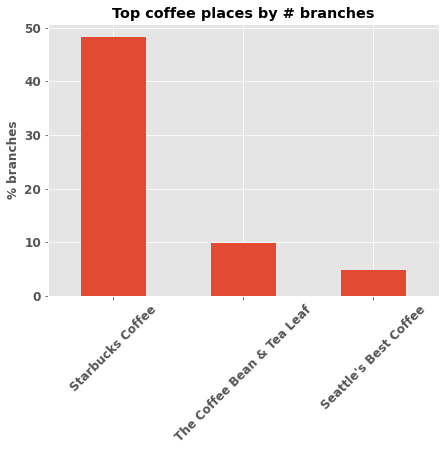

In [7]:
fig, ax = plt.subplots()
(coffee['name'].value_counts()*100/len(coffee)).head(3).plot(
    ax=ax, kind='bar',
    title ="Top coffee places by # branches",
    ylabel='% branches',
    figsize=(7,5), fontsize=12, rot=45)

The top 3 most common coffee places by the # of branches are:
1. Starbucks - comprises almost 50% of coffee shops in the dataset
2. CBTL - comprises about 10% of coffee shops in the dataset
3. Seattle's Best Coffee - comprises about 5% of coffee shops in the dataset

In [8]:
coffee['name'].value_counts()

Starbucks Coffee                                 151
The Coffee Bean & Tea Leaf                        31
Seattle's Best Coffee                             15
Bo's Coffee                                        7
UCC Vienna Café                                    6
J.CO Donuts & Coffee                               5
UCC Café Terrace                                   5
Toby's Estate Coffee Roasters                      3
UCC Park Café                                      3
Tully's Coffee                                     2
D' Cream Coffee & Tea                              2
Illy Café Delizio                                  2
Costa Coffee                                       2
LUNA Specialty Coffee                              1
Creme Cafe and Tea Bar                             1
Blenz Coffee                                       1
Waroeng Coffee Shop                                1
Ala Eh! Cafe Amadeo                                1
The Cafe Uno                                  

<a id="question_2"></a>

## 2. What is the latitude variance and longitude variance, and explain why these variances are different.

In [9]:
coffee.describe()

,lat,lng,checkins
count,313.000000,313.000000,313.000000
mean,14.576405,121.036301,6261.146965
std,0.084305,0.039372,6268.944422
min,14.102268,120.860697,1.000000
25%,14.551362,121.019758,1159.000000
50%,14.575758,121.034795,4823.000000
75%,14.617451,121.056043,9390.000000
max,14.869520,121.251941,40149.000000


In [10]:
print(f'Latitude variance: {coffee["lat"].var()}')
print(f'Longitude variance: {coffee["lng"].var()}')

Latitude variance: 0.007107412237131476
Longitude variance: 0.0015501164317026077


Latitude and longitude are in degrees, so variances look small in magnitude. In addition, there is more variance in latitude than longitude, which means the observations are more spread out from north to south than from west to east. These variances will influence the choice of epsilon value and the resulting DBSCAN clusters.

In [11]:
basemap = folium.Map(location=[14.5562297,121.0204097], tiles="cartodbdark_matter", zoom_start=15)

for index, row in coffee.iterrows():
    folium.CircleMarker([row["lat"], row["lng"]], radius=5, fill=True,
                        popup = folium.Popup(row["name"], parse_html=True),
                        tooltip = folium.Tooltip("lat:" + str(row["lat"]) + ", lng:" + str(row["lng"]))
                       ).add_to(basemap)
    

basemap

<a id="question_3"></a>

## 3. Explain what KMeans inertia is and how different it is from DBSCAN epsilon.

These are the definitions of __[Kmeans inertia](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)__ and __[DBSCAN epsilon](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN)__ according to sklearn:
- KMeans inertia: Sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided.
- DBSCAN epsilon: The maximum distance between two samples for one to be considered as in the neighborhood of the other.

And here's how I understand the differences between the two:
- **KMeans inertia** is an attribute that measures the "belongingness" of points to a cluster in terms of their distances to the cluster centroid; thus, it is a metric for assessing how well Kmeans clustering performed. The lower the inertia, the closer the points are to their centroid and the better the clustering. 
- On the other hand, **DBSCAN epsilon** is a parameter that determines the "circle of influence" of a point, or how far other points can be such that they are still included in calculating density. Unlike KMeans inertia, DBSCAN epsilon must be chosen before performing clustering.

### 3.1 Visualizing KMeans Inertia

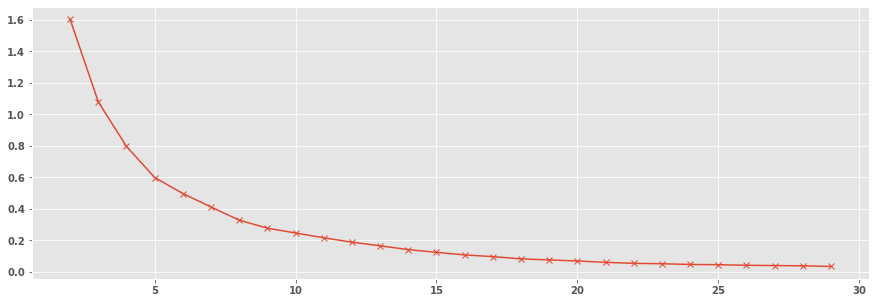

In [12]:
X = np.array(coffee[["lng", "lat"]].values.tolist())

# Elbow method to find ideal k
inertias = []
for k in range(2,30):
    kmeans = KMeans(n_clusters=k,
                random_state=18)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

fig, ax = plt.subplots()
ax.plot(range(2,30), inertias, 'x-')
plt.show()

# Maybe k is around 4 or 5? Hard to say from graph

In [13]:
def visualize_kmeans(k, df, loc_type):
    kmeans_clusters = df.copy(deep=True)
    kmeans = KMeans(n_clusters=k, random_state=18).fit(kmeans_clusters[['lng', 'lat']])
    kmeans_clusters['cluster'] = kmeans.labels_
    lng = [center[0] for center in kmeans.cluster_centers_]
    lat = [center[1] for center in kmeans.cluster_centers_]

    fig, ax = plt.subplots(figsize=(8,10))

    # Plot all observations with color based on cluster assignment
    ax.scatter(kmeans_clusters['lng'], kmeans_clusters['lat'], c=kmeans_clusters['cluster'], s=50, cmap='viridis')

    # Plot cluster centroids
    ax.scatter(lng, lat, s=100, c='r', label='cluster centroids')

    cluster_dict = {}
    for c in kmeans_clusters['cluster'].unique():
        cluster_dict[f'{c}'] = kmeans_clusters[kmeans_clusters['cluster']==c]

    # Show distances (lines) of observations to centroid of their cluster
    for key in cluster_dict.keys():
        for _, point in cluster_dict[key].iterrows():
            ax.plot([point['lng'], lng[int(key)]], [point['lat'], lat[int(key)]], c='k', ls=':', alpha=0.4)

    # Add labels, title, legend
    ax.legend()
    plt.title(f'KMeans Clustering of {loc_type} (k={k}, inertia={kmeans.inertia_})')
    plt.xlabel('Longitude (in degrees)')
    plt.ylabel('Latitude (in degrees)')

    return kmeans_clusters

,id,name,lat,lng,checkins,address,cluster
0,4b78d398f964a520cee32ee3,Starbucks Coffee,14.734710,121.057599,10428,"Ground Flr, SM City Fairview (Annex 1)",1
1,53055beb498e87041e7204f9,Starbucks Coffee,14.735735,121.060213,3793,"Fairview Terraces, Quirino Hwy",1
2,4bc1f1a6f8219c74a0f7b310,The Coffee Bean & Tea Leaf,14.736308,121.058135,17441,"G/F Gateway Mall, Gen Roxas Ave",1
3,4e5b077352b1b78b81b213b9,Starbucks Coffee,14.734639,121.059474,4116,"2nd Flr, SM City Fairview (Main Bldg)",1
4,4ceb3522e888f04d2161516b,Starbucks Coffee,14.553593,121.050662,40149,"Crossroads, Bonifacio Global City",1
...,...,...,...,...,...,...,...
308,4ba4e69ef964a520dac038e3,Starbucks Coffee,14.610225,121.079915,6875,"4th Flr, Eastwood Mall",1
309,4cc412bd3d7fa1cdb2a9a95f,Ghenne's Coffee Shop,14.603783,121.079698,208,Shopwise,1
310,4e3758efd164374eb6867059,Dexter's Bakeshop & Coffee Shop,14.612650,121.070580,233,White Plains,1
311,573d3faf498e71521269de67,Starbucks Coffee,14.650662,121.075041,698,U.P. Town Center 2,1


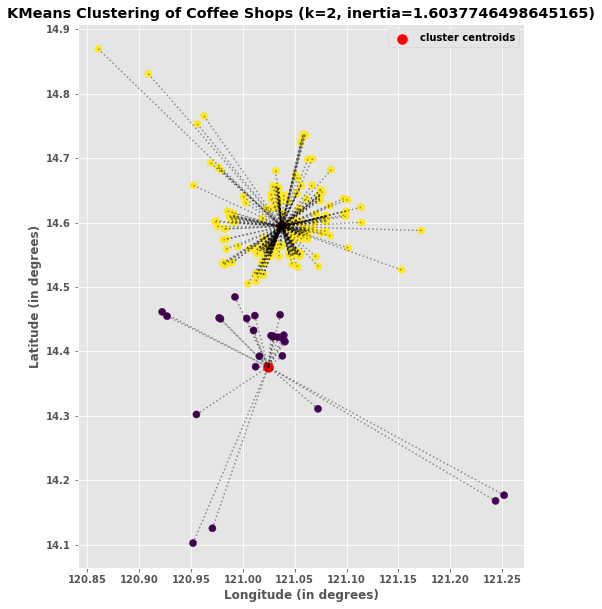

In [14]:
visualize_kmeans(2, coffee, 'Coffee Shops')

The graph above shows the clustering of coffee shops in Metro Manila using **k=2**, where yellow points belong to cluster 1 and purple points belong to cluster 0. The red points show the centroids of the clusters. Finally, the dotted lines show the distances of coffee shops to their cluster centroid. When these distances are squared and then summed, we get the ``kmeans inertia``, which in this case is around **1.60**.

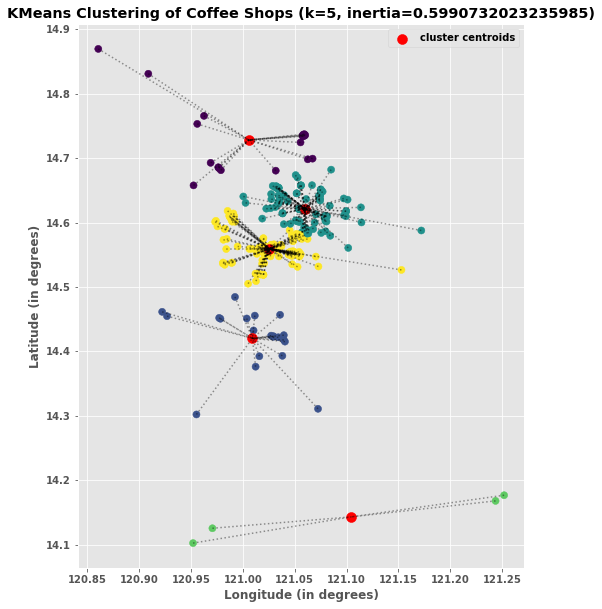

In [15]:
kmeans_clusters = visualize_kmeans(5, coffee, 'Coffee Shops')

The graph above shows the clustering of coffee shops in Metro Manila using **k=5**, where ``kmeans inertia`` is equal to around **0.6**. Because inertia is lower, it means that the observations within a cluster are closer to their centroid when using k=5 than when using k=2.

In [16]:
# Add color palette to clustering
palette = sns.color_palette("pastel", 5).as_hex()
color_getter = lambda x: palette[int(x)]
kmeans_clusters["k_color"] = kmeans_clusters["cluster"].map(color_getter)
kmeans_clusters.head()

,id,name,lat,lng,checkins,address,cluster,k_color
0,4b78d398f964a520cee32ee3,Starbucks Coffee,14.734710,121.057599,10428,"Ground Flr, SM City Fairview (Annex 1)",0,#a1c9f4
1,53055beb498e87041e7204f9,Starbucks Coffee,14.735735,121.060213,3793,"Fairview Terraces, Quirino Hwy",0,#a1c9f4
2,4bc1f1a6f8219c74a0f7b310,The Coffee Bean & Tea Leaf,14.736308,121.058135,17441,"G/F Gateway Mall, Gen Roxas Ave",0,#a1c9f4
3,4e5b077352b1b78b81b213b9,Starbucks Coffee,14.734639,121.059474,4116,"2nd Flr, SM City Fairview (Main Bldg)",0,#a1c9f4
4,4ceb3522e888f04d2161516b,Starbucks Coffee,14.553593,121.050662,40149,"Crossroads, Bonifacio Global City",4,#d0bbff


In [17]:
basemap = folium.Map(location=[14.5562297,121.0204097], tiles="cartodbdark_matter", zoom_start=15)

for index, row in kmeans_clusters.iterrows():
    folium.CircleMarker([row["lat"], row["lng"]], radius=5, fill=True, color = row["k_color"],
                        popup = folium.Popup(row["name"], parse_html=True),
                        tooltip = folium.Tooltip("lat:" + str(row["lat"]) + ", lng:" + str(row["lng"])),
                        fill_color=row["k_color"]).add_to(basemap)
    

basemap

<a id="question_4"></a>

## 4. Cluster the locations data with DBSCAN.

For DBSCAN clustering, I tried using a different distance metric: __[Haversine or great circle distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html)__, which is the angular distance between 2 points on the surface of a sphere.

I followed the __[method suggested here](https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r)__ on using k-nearest neighbors distances to find an optimal epsilon value. Specifically, I did the ff:
1. Set a ``min_samples``
2. Compute the knn distances using ``min_samples`` as ``n_neighbors``
3. Get the average distance to its ``n_neighbors`` for each point
4. Sort the average distances of all observations and plot
5. Look for the "knee" in plot & choose it as epsilon value

In [18]:
def plot_knn_distances(df, min_samples = 4):
    dbscan_clusters = df.copy(deep=True)
    
    # Plot knn distances
    dbscan_clusters['lat_rad'] = [radians(x) for x in dbscan_clusters['lat']]
    dbscan_clusters['lng_rad'] = [radians(x) for x in dbscan_clusters['lng']]

    X = dbscan_clusters[['lat_rad', 'lng_rad']]
    knn = NearestNeighbors(n_neighbors=min_samples, metric='haversine')
    knn.fit(X)
    neigh_dist, neigh_ind = knn.kneighbors(X)
    ave_neigh_dist = np.average(neigh_dist, axis=1)

    fig, ax = plt.subplots(figsize=(10,8))
    ax = plt.plot(sorted(ave_neigh_dist))
    ax = plt.yticks(np.arange(0,0.002,step=0.0001))

    plt.title(f'Average knn distance of observations (n_neighbors={min_samples}, n_observations={len(X)})')
    plt.ylabel('Average knn distance (in radians)')

    return dbscan_clusters

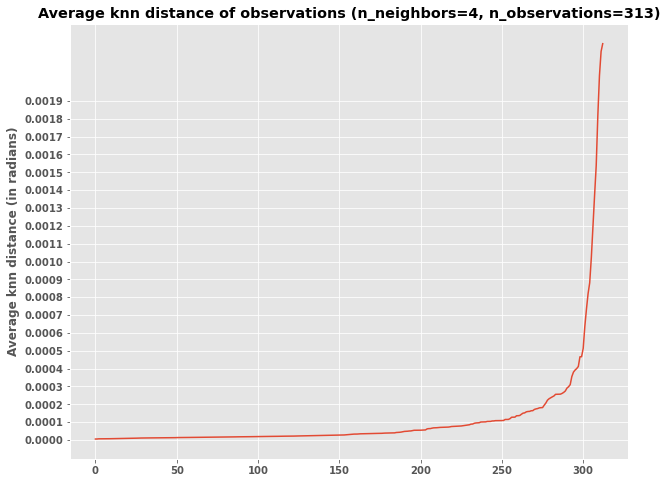

In [19]:
coffee_df = plot_knn_distances(coffee, min_samples = 4)

Similar to using the elbow method for k-means clustering, choosing epsilon from the knee of the plot of average knn distances is also difficult. I will just ``eps=0.0002``.

In [20]:
def visualize_dbscan(dbscan_clusters, min_samples, epsilon, loc_type, sample=False, n_samples=300):

    # Run DBSCAN clustering
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples).fit(
    dbscan_clusters[['lng_rad', 'lat_rad']])
    dbscan_clusters['cluster'] = dbscan.labels_
    print(f'Found {len(dbscan_clusters["cluster"].unique())} clusters...')
    print(f'Number of observations per cluster: {Counter(dbscan_clusters["cluster"])}')
    # Exclude outliers whose cluster is -1
    outliers = dbscan_clusters[dbscan_clusters['cluster']==-1]
    print(f'Excluding {len(outliers)} outliers in scatterplot & map...')
    dbscan_clusters = dbscan_clusters[dbscan_clusters['cluster'] > -1]

    # Create color map for diff clusters
    palette = sns.color_palette('dark', len(dbscan_clusters['cluster'])).as_hex()
    color_getter = lambda x: palette[int(x)]
    dbscan_clusters['db_color'] = dbscan_clusters['cluster'].map(color_getter)

    # Create scatter plot of observations w/ assigned clusters as colors
    fig, ax = plt.subplots(figsize=(15,10))
    c = plt.cm.gist_rainbow(dbscan_clusters['cluster'])
    ax = plt.scatter(dbscan_clusters['lng'], dbscan_clusters['lat'],
                     facecolors='None', edgecolors=dbscan_clusters['db_color'],
                     alpha=1, s=50)
    plt.title(f'DBSCAN Clustering of {loc_type} (min_samples={min_samples}, epsilon={epsilon})')
    plt.xlabel('Longitude (in degrees)')
    plt.ylabel('Latitude (in degrees)')

    # Visualize clusters in map
    basemap = folium.Map(location=[14.5562297,121.0204097], tiles="cartodbpositron", zoom_start=15)

    # Sample (when there are too many observations, map's not rendered)
    if sample:
        dbscan_clusters = dbscan_clusters.sample(n=n_samples, random_state=42)

    for index, row in dbscan_clusters.iterrows():
        popup = f'Name: {row["name"]}, Address: {row["address"]}'
        folium.CircleMarker([row["lat"], row["lng"]], radius=5,
                            fill=True, color = row["db_color"],
                            popup = folium.Popup(popup, parse_html=True),
                            tooltip = folium.Tooltip("lat:" + str(row["lat"]) + ", lng:" + str(row["lng"]))
                           ).add_to(basemap)

    return dbscan_clusters, basemap

Found 13 clusters...
Number of observations per cluster: Counter({1: 98, -1: 59, 3: 56, 2: 26, 6: 16, 5: 13, 8: 12, 0: 7, 7: 7, 4: 6, 11: 5, 9: 4, 10: 4})
Excluding 59 outliers in scatterplot & map...


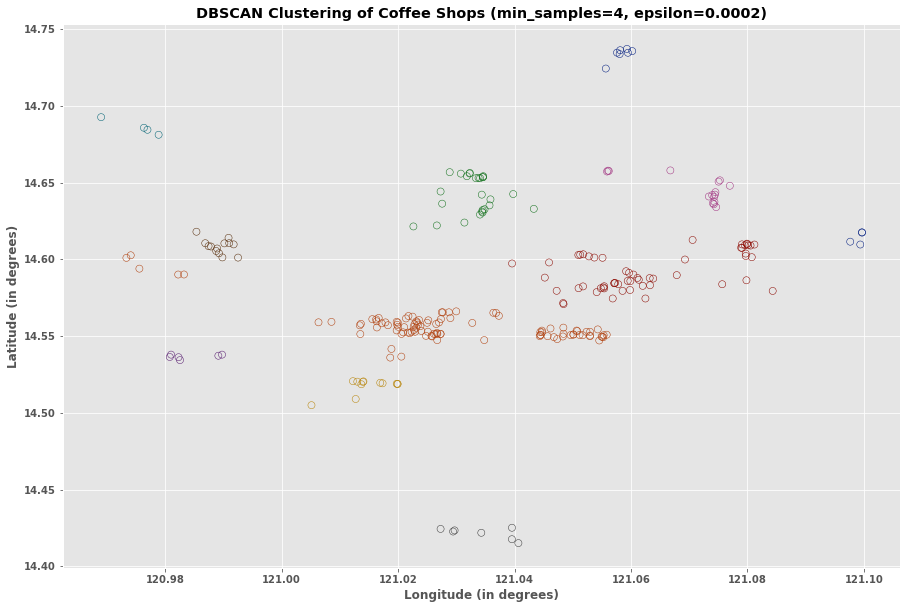

In [21]:
coffee_clusters, coffee_map = visualize_dbscan(coffee_df,
                                               min_samples=4, epsilon=0.0002,
                                               loc_type="Coffee Shops")

In [22]:
coffee_clusters

,id,name,lat,lng,checkins,address,lat_rad,lng_rad,cluster,db_color
0,4b78d398f964a520cee32ee3,Starbucks Coffee,14.734710,121.057599,10428,"Ground Flr, SM City Fairview (Annex 1)",0.257169,2.112854,0,#001c7f
1,53055beb498e87041e7204f9,Starbucks Coffee,14.735735,121.060213,3793,"Fairview Terraces, Quirino Hwy",0.257187,2.112899,0,#001c7f
2,4bc1f1a6f8219c74a0f7b310,The Coffee Bean & Tea Leaf,14.736308,121.058135,17441,"G/F Gateway Mall, Gen Roxas Ave",0.257197,2.112863,0,#001c7f
3,4e5b077352b1b78b81b213b9,Starbucks Coffee,14.734639,121.059474,4116,"2nd Flr, SM City Fairview (Main Bldg)",0.257168,2.112886,0,#001c7f
4,4ceb3522e888f04d2161516b,Starbucks Coffee,14.553593,121.050662,40149,"Crossroads, Bonifacio Global City",0.254008,2.112733,1,#b1400d
...,...,...,...,...,...,...,...,...,...,...
308,4ba4e69ef964a520dac038e3,Starbucks Coffee,14.610225,121.079915,6875,"4th Flr, Eastwood Mall",0.254997,2.113243,3,#8c0800
309,4cc412bd3d7fa1cdb2a9a95f,Ghenne's Coffee Shop,14.603783,121.079698,208,Shopwise,0.254884,2.113239,3,#8c0800
310,4e3758efd164374eb6867059,Dexter's Bakeshop & Coffee Shop,14.612650,121.070580,233,White Plains,0.255039,2.113080,3,#8c0800
311,573d3faf498e71521269de67,Starbucks Coffee,14.650662,121.075041,698,U.P. Town Center 2,0.255702,2.113158,6,#a23582


In [23]:
coffee_map.save('coffeeshops_dbclusters.html')
coffee_map

<a id="question_5"></a>

## 5. Present an analysis of the data following the DBSCAN results.

### 5.1 Explain what the clusters mean
- The clusters represent coffee drinking "hot spots" or areas with coffee shops that are close to one another. Looking at the map above, it seems like coffee companies set up shops in busy places with a high demand for coffee such as business districts (Ayala, BGC, Ortigas, Alabang), "university districts" (University Belt in Manila, Katipunan Avenue in QC), and near the NAIA.
- Some clusters span cities. For example, coffee shops in BGC and Ayala are clustered together because Ayala, Makati and BGC, Taguig are just on opposite sides of EDSA. Coffee shops in Mandaluyong; Ortigas, Pasig; and Eastwood, QC are also grouped together in another cluster.
- Some cities have multiple clusters. For example, Manila has a cluster of coffee shops near Intramuros and another cluster near the University Belt. QC has a cluster of coffee shops in Katipunan Avenue and another cluster near the Triangle Park + Tomas Morato area. Some coffee shops in QC are also in another cluster with coffee shops in Mandaluyong and Pasig. That's understandable because QC has a large area, and some of its brgys are close to its city boundaries.

**BGC-Ayala Cluster** is the densest cluster where a high number of coffee shops are located. Since BGC and Ayala are business districts, there's a high demand for coffee with many employees taking coffee breaks. If we look at this cluster, we'll see that there are many Starbucks coffee shops that are within 5-10 minutes walking distance of each other. However, having many branches close to each other isn't necessarily a bad strategy. Many coffee shops are located in office buildings, and that makes it convenient for employees in those buildings who only have short afternoon breaks.

In [24]:
coffee_clusters[coffee_clusters['cluster']==1]

,id,name,lat,lng,checkins,address,lat_rad,lng_rad,cluster,db_color
4,4ceb3522e888f04d2161516b,Starbucks Coffee,14.553593,121.050662,40149,"Crossroads, Bonifacio Global City",0.254008,2.112733,1,#b1400d
6,4dd26268cc3f7f8c122e7e1e,Starbucks Coffee,14.552860,121.025119,28782,"Ground Flr, 6750 Ayala Tower, 6750 Ayala Ave",0.253995,2.112287,1,#b1400d
12,4ba0363ef964a520da6137e3,Starbucks Coffee,14.553699,121.019758,15887,"Ground Flr, Greenbelt 1, Paseo de Roxas Ave",0.254010,2.112193,1,#b1400d
13,4b8cf865f964a520b2e232e3,Starbucks Coffee,14.551092,121.050121,19120,"B:3 Bonifacio High Street, 7th Ave",0.253964,2.112723,1,#b1400d
17,4bc0831f920eb713c0fe182c,Starbucks Coffee,14.550895,121.055828,10776,"Ground Flr, Market! Market!",0.253961,2.112823,1,#b1400d
20,4b5d3d15f964a520725729e3,Starbucks Coffee,14.561061,121.027365,11686,"G/F Pacific Star Bldg, Makati Ave",0.254138,2.112326,1,#b1400d
24,4b605b82f964a52086e129e3,Starbucks Coffee,14.562671,121.022494,9612,"G/F, GS Yupangco Bldg, Jupiter St",0.254167,2.112241,1,#b1400d
25,50c933bce4b0ae820c015375,The Coffee Bean & Tea Leaf,14.550153,121.024796,7921,"Ground Flr, Glorietta 2",0.253948,2.112281,1,#b1400d
29,4c6c91a765eda093007c4cd0,Starbucks Coffee,14.551975,121.022022,25435,"G/F Greenbelt 3, Makati Ave",0.253980,2.112233,1,#b1400d
30,5007dba2e4b09da853ad40cb,The Coffee Bean & Tea Leaf,14.552445,121.020872,15337,"G/F Greenbelt 5, Greenbelt Dr",0.253988,2.112213,1,#b1400d


On the other end of coffee shop density are **Valenzuela Cluster** and **Dela Paz, Pasig Cluster**, with only a few number of coffee shops. Either there isn't a demand for coffee in these areas (due to being far from busy areas like business districts or universities) or coffee shops just haven't started servicing these areas.

In [25]:
coffee_clusters[coffee_clusters['cluster']==9]

,id,name,lat,lng,checkins,address,lat_rad,lng_rad,cluster,db_color
89,5710a159498eee1ad929f3c5,Starbucks Coffee,14.685767,120.976359,1185,"Ground Flr, SM Center Valenzuela, MacArthur Hwy",0.256315,2.111436,9,#006374
90,5077a857e4b05b62b20a8ee8,Tully's Coffee,14.692673,120.969005,3805,"304 MacArthur Hwy, Brgy Karuhatan",0.256436,2.111307,9,#006374
98,505ee191e4b069649f3adb2f,D' Cream Coffee & Tea,14.684454,120.976964,392,"G/F SM Center Valenzuela, McArthur Hwy",0.256292,2.111446,9,#006374
100,524ab628498e4e1eb2c5993c,Roots and Herbs Coffee Shop,14.681205,120.978880,217,"McArthur Hwy, Marulas",0.256235,2.111480,9,#006374


In [26]:
coffee_clusters[coffee_clusters['cluster']==10]

,id,name,lat,lng,checkins,address,lat_rad,lng_rad,cluster,db_color
119,4e0c6434aeb7af850d68112c,Cafe Agnes,14.617451,121.099672,117,Sta. Lucia East Grand mall,0.255123,2.113588,10,#001c7f
130,4c16396b82a3c9b6acedfff8,Starbucks Coffee,14.617627,121.099656,9206,"Ground Flr, Sta. Lucia East Grand Mall",0.255126,2.113588,10,#001c7f
166,57d2c067498e55c54c14fb53,Café Molave,14.611520,121.097644,19,"#28 Molave St. Octagon Village, Brgy Dela Paz",0.255019,2.113553,10,#001c7f
168,5183bb64498e5e7bca67ea9f,Coffee shop saint anthony,14.609671,121.099370,2,Ground floor,0.254987,2.113583,10,#001c7f


### 5.2 What does the # of clusters tell us?
The number of clusters tells us the number of "hubs" with a high concentration of coffee shops, probably reflecting demand for coffee, as well as the level of "busyness" in an area.

### 5.3 What is this information useful for?
- This information can be used by coffee companies like Starbucks to analyze how their chain of coffee shops are servicing different geographic areas and make business decisions using location-based information.
    - For areas with lots of competitors, they could re-assess their strategies to outperform competing brands, e.g., offer more promos or discounts in shops located in denser areas.
    - For areas they're not serving, they could consider setting up branches here and capture the addressable market before their competitors, but they also need to check first if there's demand for coffee in these areas.  

***Scenario 1:***
- Because of the pandemic, many people order coffee through delivery apps like Grab or FoodPanda instead of visiting and staying in coffee shops. Due to lower revenues, Starbucks wants to cut down costs and close some of its shops temporarily.
- Using a cluster analysis of its shops, it's able to identify shops that are very close to one another and visualize them in a map like the one below.
- Starbucks can then use cluster info together with other business metrics like the average number of customers served each month, the number of staff/capacity, costs and revenues to decided which shops to close.
- For example, in Ayala CBD,say, the Starbucks in (LOCATION A) has high business cost compared to its revenues and average number of customers served. With the Starbucks in (LOCATION B) just a few minutes away, it could serve the demand that (LOCATION A) used to serve if (LOCATION B) would be closed. Dine-in, take-out, and delivery orders that used to be handled by (LOCATION A) would now be handled by (LOCATION B).

***Scenario 2:***
- Starbucks wants to efficiently schedule the delivery of ingredients and source its ingredients from the closest suppliers to its shops.
- Using a cluster analysis of its shops, it's able to identify shops that are very close to one another and visualize them in a map like the one below w/ the ff. clusters:
    - Ayala + BGC Cluster
    - Shaw + Ortigas Cluster
    - E. Rodriguez Ave / Eastwood Cluster
    - QC Cluster
    - Intramuros Cluster
    - UBelt Cluster
- Starbucks can then find one supplier for each cluster, and that supplier can deliver the ingredients to all the shops in the same cluster on the same day.

**Starbucks Map**

Found 7 clusters...
Number of observations per cluster: Counter({-1: 56, 0: 46, 2: 22, 1: 14, 3: 5, 4: 4, 5: 4})
Excluding 56 outliers in scatterplot & map...


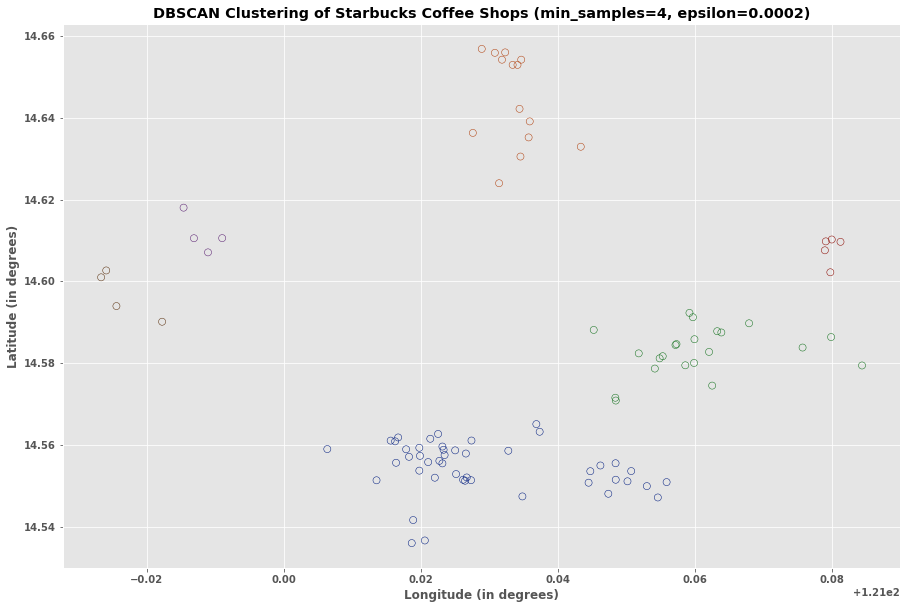

In [27]:
starbucks_df = coffee_df[coffee_df['name']=='Starbucks Coffee']
starbucks_clusters, starbucks_map = visualize_dbscan(starbucks_df,
                                               min_samples=4, epsilon=0.0002,
                                               loc_type="Starbucks Coffee Shops")

In [28]:
starbucks_map